In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                            | 0/50000 [00:00<?, ?it/s]

  8%|█████                                                         | 4081/50000 [00:00<00:01, 40808.38it/s]

 17%|██████████▎                                                   | 8325/50000 [00:00<00:00, 41767.05it/s]

 26%|███████████████▌                                             | 12795/50000 [00:00<00:00, 43104.46it/s]

 34%|█████████████████████                                        | 17223/50000 [00:00<00:00, 43566.17it/s]

 43%|██████████████████████████▍                                  | 21682/50000 [00:00<00:00, 43934.83it/s]

 52%|███████████████████████████████▊                             | 26076/50000 [00:00<00:00, 42627.85it/s]

 61%|█████████████████████████████████████▏                       | 30504/50000 [00:00<00:00, 43154.83it/s]

 70%|██████████████████████████████████████████▍                  | 34826/50000 [00:00<00:00, 42707.68it/s]

 78%|███████████████████████████████████████████████▋             | 39102/50000 [00:00<00:00, 41725.72it/s]

 87%|████████████████████████████████████████████████████▊        | 43281/50000 [00:01<00:00, 40493.70it/s]

 95%|█████████████████████████████████████████████████████████▊   | 47376/50000 [00:01<00:00, 40625.74it/s]

100%|█████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 41863.80it/s]

Files already downloaded and verified


  0%|                                                                            | 0/10000 [00:00<?, ?it/s]

 40%|████████████████████████▉                                     | 4014/10000 [00:00<00:00, 40132.10it/s]

 82%|██████████████████████████████████████████████████▉           | 8220/10000 [00:00<00:00, 41262.15it/s]

100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 41002.36it/s]

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 za51lfb3


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                              | 0/313 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/313 [00:00<03:11,  1.63it/s]

  1%|▋                                                                     | 3/313 [00:00<01:05,  4.73it/s]

  2%|█                                                                     | 5/313 [00:00<00:42,  7.20it/s]

  2%|█▌                                                                    | 7/313 [00:01<00:33,  9.07it/s]

  3%|██                                                                    | 9/313 [00:01<00:29, 10.47it/s]

  4%|██▍                                                                  | 11/313 [00:01<00:26, 11.49it/s]

  4%|██▊                                                                  | 13/313 [00:01<00:24, 12.21it/s]

  5%|███▎                                                                 | 15/313 [00:01<00:23, 12.72it/s]

  5%|███▋                                                                 | 17/313 [00:01<00:22, 13.11it/s]

  6%|████▏                                                                | 19/313 [00:01<00:21, 13.38it/s]

  7%|████▋                                                                | 21/313 [00:02<00:21, 13.57it/s]

  7%|█████                                                                | 23/313 [00:02<00:21, 13.70it/s]

  8%|█████▌                                                               | 25/313 [00:02<00:20, 13.80it/s]

  9%|█████▉                                                               | 27/313 [00:02<00:20, 13.88it/s]

  9%|██████▍                                                              | 29/313 [00:02<00:20, 13.92it/s]

 10%|██████▊                                                              | 31/313 [00:02<00:20, 13.94it/s]

 11%|███████▎                                                             | 33/313 [00:02<00:20, 13.95it/s]

 11%|███████▋                                                             | 35/313 [00:03<00:19, 13.97it/s]

 12%|████████▏                                                            | 37/313 [00:03<00:19, 13.99it/s]

 12%|████████▌                                                            | 39/313 [00:03<00:19, 13.99it/s]

 13%|█████████                                                            | 41/313 [00:03<00:19, 14.00it/s]

 14%|█████████▍                                                           | 43/313 [00:03<00:19, 14.00it/s]

 14%|█████████▉                                                           | 45/313 [00:03<00:19, 14.01it/s]

 15%|██████████▎                                                          | 47/313 [00:03<00:18, 14.02it/s]

 16%|██████████▊                                                          | 49/313 [00:04<00:18, 14.02it/s]

 16%|███████████▏                                                         | 51/313 [00:04<00:18, 14.02it/s]

 17%|███████████▋                                                         | 53/313 [00:04<00:18, 14.02it/s]

 18%|████████████                                                         | 55/313 [00:04<00:18, 14.02it/s]

 18%|████████████▌                                                        | 57/313 [00:04<00:18, 14.02it/s]

 19%|█████████████                                                        | 59/313 [00:04<00:18, 14.03it/s]

 19%|█████████████▍                                                       | 61/313 [00:04<00:17, 14.02it/s]

 20%|█████████████▉                                                       | 63/313 [00:05<00:17, 14.02it/s]

 21%|██████████████▎                                                      | 65/313 [00:05<00:17, 14.02it/s]

 21%|██████████████▊                                                      | 67/313 [00:05<00:17, 14.02it/s]

 22%|███████████████▏                                                     | 69/313 [00:05<00:17, 13.99it/s]

 23%|███████████████▋                                                     | 71/313 [00:05<00:17, 13.99it/s]

 23%|████████████████                                                     | 73/313 [00:05<00:17, 14.00it/s]

 24%|████████████████▌                                                    | 75/313 [00:05<00:16, 14.01it/s]

 25%|████████████████▉                                                    | 77/313 [00:06<00:16, 14.01it/s]

 25%|█████████████████▍                                                   | 79/313 [00:06<00:16, 14.02it/s]

 26%|█████████████████▊                                                   | 81/313 [00:06<00:16, 14.02it/s]

 27%|██████████████████▎                                                  | 83/313 [00:06<00:16, 14.03it/s]

 27%|██████████████████▋                                                  | 85/313 [00:06<00:16, 14.03it/s]

 28%|███████████████████▏                                                 | 87/313 [00:06<00:16, 14.00it/s]

 28%|███████████████████▌                                                 | 89/313 [00:06<00:15, 14.01it/s]

 29%|████████████████████                                                 | 91/313 [00:07<00:15, 14.02it/s]

 30%|████████████████████▌                                                | 93/313 [00:07<00:15, 14.03it/s]

 30%|████████████████████▉                                                | 95/313 [00:07<00:15, 14.03it/s]

 31%|█████████████████████▍                                               | 97/313 [00:07<00:15, 14.04it/s]

 32%|█████████████████████▊                                               | 99/313 [00:07<00:15, 14.04it/s]

 32%|█████████████████████▉                                              | 101/313 [00:07<00:15, 14.04it/s]

 33%|██████████████████████▍                                             | 103/313 [00:07<00:14, 14.03it/s]

 34%|██████████████████████▊                                             | 105/313 [00:08<00:14, 14.02it/s]

 34%|███████████████████████▏                                            | 107/313 [00:08<00:14, 14.02it/s]

 35%|███████████████████████▋                                            | 109/313 [00:08<00:14, 14.02it/s]

 35%|████████████████████████                                            | 111/313 [00:08<00:14, 14.01it/s]

 36%|████████████████████████▌                                           | 113/313 [00:08<00:14, 14.02it/s]

 37%|████████████████████████▉                                           | 115/313 [00:08<00:14, 14.03it/s]

 37%|█████████████████████████▍                                          | 117/313 [00:08<00:13, 14.02it/s]

 38%|█████████████████████████▊                                          | 119/313 [00:09<00:13, 14.02it/s]

 39%|██████████████████████████▎                                         | 121/313 [00:09<00:13, 14.02it/s]

 39%|██████████████████████████▋                                         | 123/313 [00:09<00:13, 14.01it/s]

 40%|███████████████████████████▏                                        | 125/313 [00:09<00:13, 14.02it/s]

 41%|███████████████████████████▌                                        | 127/313 [00:09<00:13, 14.02it/s]

 41%|████████████████████████████                                        | 129/313 [00:09<00:13, 14.02it/s]

 42%|████████████████████████████▍                                       | 131/313 [00:09<00:12, 14.02it/s]

 42%|████████████████████████████▉                                       | 133/313 [00:10<00:12, 14.02it/s]

 43%|█████████████████████████████▎                                      | 135/313 [00:10<00:12, 14.02it/s]

 44%|█████████████████████████████▊                                      | 137/313 [00:10<00:12, 14.03it/s]

 44%|██████████████████████████████▏                                     | 139/313 [00:10<00:12, 14.02it/s]

 45%|██████████████████████████████▋                                     | 141/313 [00:10<00:12, 14.02it/s]

 46%|███████████████████████████████                                     | 143/313 [00:10<00:12, 14.02it/s]

 46%|███████████████████████████████▌                                    | 145/313 [00:10<00:11, 14.02it/s]

 47%|███████████████████████████████▉                                    | 147/313 [00:11<00:11, 14.00it/s]

 48%|████████████████████████████████▎                                   | 149/313 [00:11<00:11, 14.01it/s]

 48%|████████████████████████████████▊                                   | 151/313 [00:11<00:11, 14.01it/s]

 49%|█████████████████████████████████▏                                  | 153/313 [00:11<00:11, 14.02it/s]

 50%|█████████████████████████████████▋                                  | 155/313 [00:11<00:11, 14.02it/s]

 50%|██████████████████████████████████                                  | 157/313 [00:11<00:11, 14.03it/s]

 51%|██████████████████████████████████▌                                 | 159/313 [00:11<00:10, 14.03it/s]

 51%|██████████████████████████████████▉                                 | 161/313 [00:12<00:10, 14.03it/s]

 52%|███████████████████████████████████▍                                | 163/313 [00:12<00:10, 14.04it/s]

 53%|███████████████████████████████████▊                                | 165/313 [00:12<00:10, 14.04it/s]

 53%|████████████████████████████████████▎                               | 167/313 [00:12<00:10, 14.03it/s]

 54%|████████████████████████████████████▋                               | 169/313 [00:12<00:10, 13.98it/s]

 55%|█████████████████████████████████████▏                              | 171/313 [00:12<00:10, 13.98it/s]

 55%|█████████████████████████████████████▌                              | 173/313 [00:12<00:10, 13.99it/s]

 56%|██████████████████████████████████████                              | 175/313 [00:13<00:09, 13.99it/s]

 57%|██████████████████████████████████████▍                             | 177/313 [00:13<00:09, 14.00it/s]

 57%|██████████████████████████████████████▉                             | 179/313 [00:13<00:09, 14.01it/s]

 58%|███████████████████████████████████████▎                            | 181/313 [00:13<00:09, 14.01it/s]

 58%|███████████████████████████████████████▊                            | 183/313 [00:13<00:09, 14.02it/s]

 59%|████████████████████████████████████████▏                           | 185/313 [00:13<00:09, 14.03it/s]

 60%|████████████████████████████████████████▋                           | 187/313 [00:13<00:08, 14.03it/s]

 60%|█████████████████████████████████████████                           | 189/313 [00:14<00:08, 14.03it/s]

 61%|█████████████████████████████████████████▍                          | 191/313 [00:14<00:08, 14.02it/s]

 62%|█████████████████████████████████████████▉                          | 193/313 [00:14<00:08, 14.03it/s]

 62%|██████████████████████████████████████████▎                         | 195/313 [00:14<00:08, 14.03it/s]

 63%|██████████████████████████████████████████▊                         | 197/313 [00:14<00:08, 14.02it/s]

 64%|███████████████████████████████████████████▏                        | 199/313 [00:14<00:08, 14.03it/s]

 64%|███████████████████████████████████████████▋                        | 201/313 [00:14<00:07, 14.03it/s]

 65%|████████████████████████████████████████████                        | 203/313 [00:15<00:07, 14.02it/s]

 65%|████████████████████████████████████████████▌                       | 205/313 [00:15<00:07, 14.02it/s]

 66%|████████████████████████████████████████████▉                       | 207/313 [00:15<00:07, 14.02it/s]

 67%|█████████████████████████████████████████████▍                      | 209/313 [00:15<00:07, 14.03it/s]

 67%|█████████████████████████████████████████████▊                      | 211/313 [00:15<00:07, 14.03it/s]

 68%|██████████████████████████████████████████████▎                     | 213/313 [00:15<00:07, 14.03it/s]

 69%|██████████████████████████████████████████████▋                     | 215/313 [00:15<00:06, 14.02it/s]

 69%|███████████████████████████████████████████████▏                    | 217/313 [00:16<00:06, 14.02it/s]

 70%|███████████████████████████████████████████████▌                    | 219/313 [00:16<00:06, 14.03it/s]

 71%|████████████████████████████████████████████████                    | 221/313 [00:16<00:06, 14.02it/s]

 71%|████████████████████████████████████████████████▍                   | 223/313 [00:16<00:06, 14.03it/s]

 72%|████████████████████████████████████████████████▉                   | 225/313 [00:16<00:06, 14.03it/s]

 73%|█████████████████████████████████████████████████▎                  | 227/313 [00:16<00:06, 14.03it/s]

 73%|█████████████████████████████████████████████████▊                  | 229/313 [00:16<00:05, 14.03it/s]

 74%|██████████████████████████████████████████████████▏                 | 231/313 [00:17<00:05, 14.03it/s]

 74%|██████████████████████████████████████████████████▌                 | 233/313 [00:17<00:05, 14.04it/s]

 75%|███████████████████████████████████████████████████                 | 235/313 [00:17<00:05, 14.03it/s]

 76%|███████████████████████████████████████████████████▍                | 237/313 [00:17<00:05, 14.03it/s]

 76%|███████████████████████████████████████████████████▉                | 239/313 [00:17<00:05, 14.04it/s]

 77%|████████████████████████████████████████████████████▎               | 241/313 [00:17<00:05, 14.04it/s]

 78%|████████████████████████████████████████████████████▊               | 243/313 [00:17<00:04, 14.05it/s]

 78%|█████████████████████████████████████████████████████▏              | 245/313 [00:18<00:04, 14.05it/s]

 79%|█████████████████████████████████████████████████████▋              | 247/313 [00:18<00:04, 14.05it/s]

 80%|██████████████████████████████████████████████████████              | 249/313 [00:18<00:04, 14.03it/s]

 80%|██████████████████████████████████████████████████████▌             | 251/313 [00:18<00:04, 14.02it/s]

 81%|██████████████████████████████████████████████████████▉             | 253/313 [00:18<00:04, 12.94it/s]

 81%|███████████████████████████████████████████████████████▍            | 255/313 [00:18<00:04, 11.88it/s]

 82%|███████████████████████████████████████████████████████▊            | 257/313 [00:19<00:04, 11.23it/s]

 83%|████████████████████████████████████████████████████████▎           | 259/313 [00:19<00:04, 11.23it/s]

 83%|████████████████████████████████████████████████████████▋           | 261/313 [00:19<00:05,  9.63it/s]

 84%|█████████████████████████████████████████████████████████▏          | 263/313 [00:19<00:04, 10.23it/s]

 85%|█████████████████████████████████████████████████████████▌          | 265/313 [00:19<00:05,  8.73it/s]

 85%|█████████████████████████████████████████████████████████▊          | 266/313 [00:20<00:05,  8.22it/s]

 85%|██████████████████████████████████████████████████████████          | 267/313 [00:20<00:05,  7.77it/s]

 86%|██████████████████████████████████████████████████████████▏         | 268/313 [00:20<00:06,  7.40it/s]

 86%|██████████████████████████████████████████████████████████▍         | 269/313 [00:20<00:06,  7.16it/s]

 86%|██████████████████████████████████████████████████████████▋         | 270/313 [00:20<00:06,  6.88it/s]

 87%|██████████████████████████████████████████████████████████▉         | 271/313 [00:20<00:06,  6.68it/s]

 87%|███████████████████████████████████████████████████████████         | 272/313 [00:21<00:06,  6.58it/s]

 87%|███████████████████████████████████████████████████████████▎        | 273/313 [00:21<00:06,  6.51it/s]

 88%|███████████████████████████████████████████████████████████▌        | 274/313 [00:21<00:06,  6.47it/s]

 88%|███████████████████████████████████████████████████████████▋        | 275/313 [00:21<00:05,  6.44it/s]

 88%|███████████████████████████████████████████████████████████▉        | 276/313 [00:21<00:05,  6.36it/s]

 88%|████████████████████████████████████████████████████████████▏       | 277/313 [00:21<00:05,  6.31it/s]

 89%|████████████████████████████████████████████████████████████▍       | 278/313 [00:22<00:05,  6.32it/s]

 89%|████████████████████████████████████████████████████████████▌       | 279/313 [00:22<00:05,  6.33it/s]

 89%|████████████████████████████████████████████████████████████▊       | 280/313 [00:22<00:05,  6.33it/s]

 90%|█████████████████████████████████████████████████████████████       | 281/313 [00:22<00:05,  6.34it/s]

 90%|█████████████████████████████████████████████████████████████▎      | 282/313 [00:22<00:04,  6.34it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 283/313 [00:22<00:04,  6.34it/s]

 91%|█████████████████████████████████████████████████████████████▋      | 284/313 [00:22<00:04,  6.33it/s]

 91%|█████████████████████████████████████████████████████████████▉      | 285/313 [00:23<00:04,  6.33it/s]

 91%|██████████████████████████████████████████████████████████████▏     | 286/313 [00:23<00:04,  6.32it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 287/313 [00:23<00:04,  6.34it/s]

 92%|██████████████████████████████████████████████████████████████▌     | 288/313 [00:23<00:03,  6.34it/s]

 92%|██████████████████████████████████████████████████████████████▊     | 289/313 [00:23<00:03,  6.40it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 291/313 [00:23<00:02,  7.86it/s]

 93%|███████████████████████████████████████████████████████████████▍    | 292/313 [00:24<00:02,  7.42it/s]

 94%|███████████████████████████████████████████████████████████████▋    | 293/313 [00:24<00:02,  7.11it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 294/313 [00:24<00:02,  6.89it/s]

 94%|████████████████████████████████████████████████████████████████    | 295/313 [00:24<00:02,  6.73it/s]

 95%|████████████████████████████████████████████████████████████████▎   | 296/313 [00:24<00:02,  6.62it/s]

 95%|████████████████████████████████████████████████████████████████▌   | 297/313 [00:24<00:02,  6.54it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 299/313 [00:25<00:01,  8.33it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 300/313 [00:25<00:01,  8.34it/s]

 96%|█████████████████████████████████████████████████████████████████▍  | 301/313 [00:25<00:01,  7.70it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 302/313 [00:25<00:01,  7.24it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 303/313 [00:25<00:01,  7.01it/s]

 97%|██████████████████████████████████████████████████████████████████  | 304/313 [00:25<00:01,  6.81it/s]

 97%|██████████████████████████████████████████████████████████████████▎ | 305/313 [00:25<00:01,  6.67it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 306/313 [00:26<00:01,  6.62it/s]

 98%|██████████████████████████████████████████████████████████████████▉ | 308/313 [00:26<00:00,  8.69it/s]

 99%|███████████████████████████████████████████████████████████████████▏| 309/313 [00:26<00:00,  8.01it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 310/313 [00:26<00:00,  7.54it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 311/313 [00:26<00:00,  7.21it/s]

100%|███████████████████████████████████████████████████████████████████▊| 312/313 [00:26<00:00,  6.99it/s]

100%|████████████████████████████████████████████████████████████████████| 313/313 [00:26<00:00, 11.62it/s]

train - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  1%|▉                                                                      | 1/79 [00:00<00:12,  6.14it/s]

  4%|██▋                                                                    | 3/79 [00:00<00:07, 10.42it/s]

  6%|████▍                                                                  | 5/79 [00:00<00:06, 11.98it/s]

  9%|██████▎                                                                | 7/79 [00:00<00:05, 12.75it/s]

 11%|████████                                                               | 9/79 [00:00<00:05, 13.18it/s]

 14%|█████████▋                                                            | 11/79 [00:00<00:05, 12.00it/s]

 16%|███████████▌                                                          | 13/79 [00:01<00:06, 10.75it/s]

 19%|█████████████▎                                                        | 15/79 [00:01<00:06, 10.02it/s]

 22%|███████████████                                                       | 17/79 [00:01<00:06,  9.60it/s]

 23%|███████████████▉                                                      | 18/79 [00:01<00:06,  9.43it/s]

 24%|████████████████▊                                                     | 19/79 [00:01<00:06,  9.28it/s]

 25%|█████████████████▋                                                    | 20/79 [00:01<00:06,  9.15it/s]

 27%|██████████████████▌                                                   | 21/79 [00:02<00:06,  9.00it/s]

 28%|███████████████████▍                                                  | 22/79 [00:02<00:06,  8.89it/s]

 29%|████████████████████▍                                                 | 23/79 [00:02<00:06,  8.80it/s]

 30%|█████████████████████▎                                                | 24/79 [00:02<00:06,  8.73it/s]

 32%|██████████████████████▏                                               | 25/79 [00:02<00:06,  8.68it/s]

 33%|███████████████████████                                               | 26/79 [00:02<00:06,  8.64it/s]

 34%|███████████████████████▉                                              | 27/79 [00:02<00:06,  8.62it/s]

 35%|████████████████████████▊                                             | 28/79 [00:02<00:05,  8.60it/s]

 37%|█████████████████████████▋                                            | 29/79 [00:03<00:05,  8.60it/s]

 38%|██████████████████████████▌                                           | 30/79 [00:03<00:05,  8.58it/s]

 39%|███████████████████████████▍                                          | 31/79 [00:03<00:05,  8.58it/s]

 41%|████████████████████████████▎                                         | 32/79 [00:03<00:05,  8.57it/s]

 42%|█████████████████████████████▏                                        | 33/79 [00:03<00:05,  8.57it/s]

 43%|██████████████████████████████▏                                       | 34/79 [00:03<00:05,  8.56it/s]

 44%|███████████████████████████████                                       | 35/79 [00:03<00:05,  8.57it/s]

 46%|███████████████████████████████▉                                      | 36/79 [00:03<00:05,  8.57it/s]

 47%|████████████████████████████████▊                                     | 37/79 [00:03<00:04,  8.57it/s]

 48%|█████████████████████████████████▋                                    | 38/79 [00:04<00:04,  8.57it/s]

 49%|██████████████████████████████████▌                                   | 39/79 [00:04<00:04,  8.57it/s]

 51%|███████████████████████████████████▍                                  | 40/79 [00:04<00:04,  8.57it/s]

 52%|████████████████████████████████████▎                                 | 41/79 [00:04<00:04,  8.56it/s]

 53%|█████████████████████████████████████▏                                | 42/79 [00:04<00:04,  8.56it/s]

 54%|██████████████████████████████████████                                | 43/79 [00:04<00:04,  8.56it/s]

 56%|██████████████████████████████████████▉                               | 44/79 [00:04<00:04,  8.56it/s]

 57%|███████████████████████████████████████▊                              | 45/79 [00:04<00:03,  8.56it/s]

 58%|████████████████████████████████████████▊                             | 46/79 [00:04<00:03,  8.55it/s]

 59%|█████████████████████████████████████████▋                            | 47/79 [00:05<00:03,  8.55it/s]

 61%|██████████████████████████████████████████▌                           | 48/79 [00:05<00:03,  8.55it/s]

 62%|███████████████████████████████████████████▍                          | 49/79 [00:05<00:03,  8.55it/s]

 63%|████████████████████████████████████████████▎                         | 50/79 [00:05<00:03,  8.55it/s]

 65%|█████████████████████████████████████████████▏                        | 51/79 [00:05<00:03,  8.55it/s]

 66%|██████████████████████████████████████████████                        | 52/79 [00:05<00:03,  8.55it/s]

 67%|██████████████████████████████████████████████▉                       | 53/79 [00:05<00:03,  8.56it/s]

 68%|███████████████████████████████████████████████▊                      | 54/79 [00:05<00:02,  8.56it/s]

 70%|████████████████████████████████████████████████▋                     | 55/79 [00:06<00:02,  8.56it/s]

 71%|█████████████████████████████████████████████████▌                    | 56/79 [00:06<00:02,  8.57it/s]

 72%|██████████████████████████████████████████████████▌                   | 57/79 [00:06<00:02,  8.57it/s]

 73%|███████████████████████████████████████████████████▍                  | 58/79 [00:06<00:02,  8.56it/s]

 75%|████████████████████████████████████████████████████▎                 | 59/79 [00:06<00:02,  8.55it/s]

 76%|█████████████████████████████████████████████████████▏                | 60/79 [00:06<00:02,  8.55it/s]

 77%|██████████████████████████████████████████████████████                | 61/79 [00:06<00:02,  8.56it/s]

 78%|██████████████████████████████████████████████████████▉               | 62/79 [00:06<00:01,  8.56it/s]

 80%|███████████████████████████████████████████████████████▊              | 63/79 [00:06<00:01,  8.57it/s]

 81%|████████████████████████████████████████████████████████▋             | 64/79 [00:07<00:01,  8.58it/s]

 82%|█████████████████████████████████████████████████████████▌            | 65/79 [00:07<00:01,  8.57it/s]

 84%|██████████████████████████████████████████████████████████▍           | 66/79 [00:07<00:01,  8.55it/s]

 85%|███████████████████████████████████████████████████████████▎          | 67/79 [00:07<00:01,  8.55it/s]

 86%|████████████████████████████████████████████████████████████▎         | 68/79 [00:07<00:01,  8.56it/s]

 87%|█████████████████████████████████████████████████████████████▏        | 69/79 [00:07<00:01,  8.56it/s]

 89%|██████████████████████████████████████████████████████████████        | 70/79 [00:07<00:01,  8.51it/s]

 90%|██████████████████████████████████████████████████████████████▉       | 71/79 [00:07<00:00,  8.53it/s]

 91%|███████████████████████████████████████████████████████████████▊      | 72/79 [00:08<00:00,  8.54it/s]

 92%|████████████████████████████████████████████████████████████████▋     | 73/79 [00:08<00:00,  8.55it/s]

 94%|█████████████████████████████████████████████████████████████████▌    | 74/79 [00:08<00:00,  8.56it/s]

 95%|██████████████████████████████████████████████████████████████████▍   | 75/79 [00:08<00:00,  8.57it/s]

 96%|███████████████████████████████████████████████████████████████████▎  | 76/79 [00:08<00:00,  8.56it/s]

 97%|████████████████████████████████████████████████████████████████████▏ | 77/79 [00:08<00:00,  8.56it/s]

 99%|█████████████████████████████████████████████████████████████████████ | 78/79 [00:08<00:00,  8.57it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.92it/s]

val - OK


  0%|                                                                               | 0/79 [00:00<?, ?it/s]

  1%|▉                                                                      | 1/79 [00:00<00:15,  5.06it/s]

  3%|█▊                                                                     | 2/79 [00:00<00:11,  6.63it/s]

  4%|██▋                                                                    | 3/79 [00:00<00:10,  7.40it/s]

  5%|███▌                                                                   | 4/79 [00:00<00:09,  7.83it/s]

  6%|████▍                                                                  | 5/79 [00:00<00:09,  8.08it/s]

  8%|█████▍                                                                 | 6/79 [00:00<00:08,  8.24it/s]

  9%|██████▎                                                                | 7/79 [00:00<00:08,  8.34it/s]

 10%|███████▏                                                               | 8/79 [00:01<00:08,  8.40it/s]

 11%|████████                                                               | 9/79 [00:01<00:08,  8.46it/s]

 13%|████████▊                                                             | 10/79 [00:01<00:08,  8.48it/s]

 14%|█████████▋                                                            | 11/79 [00:01<00:07,  8.51it/s]

 15%|██████████▋                                                           | 12/79 [00:01<00:07,  8.53it/s]

 16%|███████████▌                                                          | 13/79 [00:01<00:07,  8.54it/s]

 18%|████████████▍                                                         | 14/79 [00:01<00:07,  8.54it/s]

 19%|█████████████▎                                                        | 15/79 [00:01<00:07,  8.53it/s]

 20%|██████████████▏                                                       | 16/79 [00:01<00:07,  8.54it/s]

 22%|███████████████                                                       | 17/79 [00:02<00:07,  8.54it/s]

 23%|███████████████▉                                                      | 18/79 [00:02<00:07,  8.54it/s]

 24%|████████████████▊                                                     | 19/79 [00:02<00:07,  8.55it/s]

 25%|█████████████████▋                                                    | 20/79 [00:02<00:06,  8.55it/s]

 27%|██████████████████▌                                                   | 21/79 [00:02<00:06,  8.56it/s]

 28%|███████████████████▍                                                  | 22/79 [00:02<00:06,  8.56it/s]

 29%|████████████████████▍                                                 | 23/79 [00:02<00:06,  8.56it/s]

 30%|█████████████████████▎                                                | 24/79 [00:02<00:06,  8.55it/s]

 32%|██████████████████████▏                                               | 25/79 [00:03<00:06,  8.56it/s]

 33%|███████████████████████                                               | 26/79 [00:03<00:06,  8.55it/s]

 34%|███████████████████████▉                                              | 27/79 [00:03<00:06,  8.55it/s]

 35%|████████████████████████▊                                             | 28/79 [00:03<00:05,  8.55it/s]

 37%|█████████████████████████▋                                            | 29/79 [00:03<00:05,  8.55it/s]

 38%|██████████████████████████▌                                           | 30/79 [00:03<00:05,  8.54it/s]

 39%|███████████████████████████▍                                          | 31/79 [00:03<00:05,  8.54it/s]

 42%|█████████████████████████████▏                                        | 33/79 [00:03<00:04,  9.85it/s]

 43%|██████████████████████████████▏                                       | 34/79 [00:03<00:04,  9.56it/s]

 44%|███████████████████████████████                                       | 35/79 [00:04<00:04,  9.34it/s]

 46%|███████████████████████████████▉                                      | 36/79 [00:04<00:04,  9.17it/s]

 47%|████████████████████████████████▊                                     | 37/79 [00:04<00:04,  9.04it/s]

 48%|█████████████████████████████████▋                                    | 38/79 [00:04<00:04,  8.96it/s]

 49%|██████████████████████████████████▌                                   | 39/79 [00:04<00:04,  8.90it/s]

 51%|███████████████████████████████████▍                                  | 40/79 [00:04<00:04,  8.86it/s]

 52%|████████████████████████████████████▎                                 | 41/79 [00:04<00:04,  8.80it/s]

 53%|█████████████████████████████████████▏                                | 42/79 [00:04<00:04,  8.72it/s]

 54%|██████████████████████████████████████                                | 43/79 [00:05<00:04,  8.66it/s]

 56%|██████████████████████████████████████▉                               | 44/79 [00:05<00:04,  8.63it/s]

 57%|███████████████████████████████████████▊                              | 45/79 [00:05<00:03,  8.61it/s]

 58%|████████████████████████████████████████▊                             | 46/79 [00:05<00:03,  8.58it/s]

 59%|█████████████████████████████████████████▋                            | 47/79 [00:05<00:03,  8.57it/s]

 61%|██████████████████████████████████████████▌                           | 48/79 [00:05<00:03,  8.57it/s]

 62%|███████████████████████████████████████████▍                          | 49/79 [00:05<00:03,  8.56it/s]

 63%|████████████████████████████████████████████▎                         | 50/79 [00:05<00:03,  8.56it/s]

 65%|█████████████████████████████████████████████▏                        | 51/79 [00:05<00:03,  8.56it/s]

 66%|██████████████████████████████████████████████                        | 52/79 [00:06<00:03,  8.56it/s]

 67%|██████████████████████████████████████████████▉                       | 53/79 [00:06<00:03,  8.55it/s]

 68%|███████████████████████████████████████████████▊                      | 54/79 [00:06<00:02,  8.55it/s]

 70%|████████████████████████████████████████████████▋                     | 55/79 [00:06<00:02,  8.56it/s]

 71%|█████████████████████████████████████████████████▌                    | 56/79 [00:06<00:02,  8.55it/s]

 72%|██████████████████████████████████████████████████▌                   | 57/79 [00:06<00:02,  8.55it/s]

 73%|███████████████████████████████████████████████████▍                  | 58/79 [00:06<00:02,  8.55it/s]

 75%|████████████████████████████████████████████████████▎                 | 59/79 [00:06<00:02,  8.54it/s]

 76%|█████████████████████████████████████████████████████▏                | 60/79 [00:07<00:02,  8.54it/s]

 77%|██████████████████████████████████████████████████████                | 61/79 [00:07<00:02,  8.56it/s]

 78%|██████████████████████████████████████████████████████▉               | 62/79 [00:07<00:01,  8.56it/s]

 80%|███████████████████████████████████████████████████████▊              | 63/79 [00:07<00:01,  8.56it/s]

 81%|████████████████████████████████████████████████████████▋             | 64/79 [00:07<00:01,  8.56it/s]

 82%|█████████████████████████████████████████████████████████▌            | 65/79 [00:07<00:01,  8.56it/s]

 84%|██████████████████████████████████████████████████████████▍           | 66/79 [00:07<00:01,  8.56it/s]

 85%|███████████████████████████████████████████████████████████▎          | 67/79 [00:07<00:01,  8.55it/s]

 86%|████████████████████████████████████████████████████████████▎         | 68/79 [00:07<00:01,  8.55it/s]

 87%|█████████████████████████████████████████████████████████████▏        | 69/79 [00:08<00:01,  8.54it/s]

 89%|██████████████████████████████████████████████████████████████        | 70/79 [00:08<00:01,  8.54it/s]

 90%|██████████████████████████████████████████████████████████████▉       | 71/79 [00:08<00:00,  8.56it/s]

 91%|███████████████████████████████████████████████████████████████▊      | 72/79 [00:08<00:00,  8.56it/s]

 92%|████████████████████████████████████████████████████████████████▋     | 73/79 [00:08<00:00,  8.55it/s]

 94%|█████████████████████████████████████████████████████████████████▌    | 74/79 [00:08<00:00,  8.55it/s]

 95%|██████████████████████████████████████████████████████████████████▍   | 75/79 [00:08<00:00,  8.55it/s]

 96%|███████████████████████████████████████████████████████████████████▎  | 76/79 [00:08<00:00,  8.55it/s]

 97%|████████████████████████████████████████████████████████████████████▏ | 77/79 [00:08<00:00,  8.57it/s]

 99%|█████████████████████████████████████████████████████████████████████ | 78/79 [00:09<00:00,  8.57it/s]

100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:09<00:00,  8.58it/s]

test InD - OK


  0%|                                                                              | 0/469 [00:00<?, ?it/s]

  0%|▏                                                                     | 1/469 [00:00<01:36,  4.87it/s]

  0%|▎                                                                     | 2/469 [00:00<01:11,  6.49it/s]

  1%|▍                                                                     | 3/469 [00:00<01:03,  7.30it/s]

  1%|▌                                                                     | 4/469 [00:00<01:00,  7.74it/s]

  1%|▋                                                                     | 5/469 [00:00<00:57,  8.02it/s]

  1%|▉                                                                     | 6/469 [00:00<00:56,  8.19it/s]

  1%|█                                                                     | 7/469 [00:00<00:55,  8.31it/s]

  2%|█▏                                                                    | 8/469 [00:01<00:54,  8.38it/s]

  2%|█▎                                                                    | 9/469 [00:01<00:54,  8.44it/s]

  2%|█▍                                                                   | 10/469 [00:01<00:54,  8.46it/s]

  2%|█▌                                                                   | 11/469 [00:01<00:53,  8.48it/s]

  3%|█▊                                                                   | 12/469 [00:01<00:53,  8.50it/s]

  3%|█▉                                                                   | 13/469 [00:01<00:53,  8.52it/s]

  3%|██                                                                   | 14/469 [00:01<00:53,  8.53it/s]

  3%|██▏                                                                  | 15/469 [00:01<00:53,  8.53it/s]

  3%|██▎                                                                  | 16/469 [00:01<00:53,  8.53it/s]

  4%|██▌                                                                  | 17/469 [00:02<00:52,  8.53it/s]

  4%|██▋                                                                  | 18/469 [00:02<00:52,  8.54it/s]

  4%|██▊                                                                  | 19/469 [00:02<00:52,  8.53it/s]

  4%|██▉                                                                  | 20/469 [00:02<00:52,  8.53it/s]

  4%|███                                                                  | 21/469 [00:02<00:52,  8.54it/s]

  5%|███▏                                                                 | 22/469 [00:02<00:52,  8.54it/s]

  5%|███▍                                                                 | 23/469 [00:02<00:52,  8.55it/s]

  5%|███▌                                                                 | 24/469 [00:02<00:52,  8.55it/s]

  5%|███▋                                                                 | 25/469 [00:03<00:51,  8.57it/s]

  6%|███▊                                                                 | 26/469 [00:03<00:51,  8.58it/s]

  6%|███▉                                                                 | 27/469 [00:03<00:51,  8.56it/s]

  6%|████                                                                 | 28/469 [00:03<00:51,  8.57it/s]

  6%|████▎                                                                | 29/469 [00:03<00:51,  8.57it/s]

  6%|████▍                                                                | 30/469 [00:03<00:51,  8.56it/s]

  7%|████▌                                                                | 31/469 [00:03<00:51,  8.56it/s]

  7%|████▋                                                                | 32/469 [00:03<00:51,  8.55it/s]

  7%|████▊                                                                | 33/469 [00:03<00:51,  8.55it/s]

  7%|█████                                                                | 34/469 [00:04<00:50,  8.54it/s]

  7%|█████▏                                                               | 35/469 [00:04<00:50,  8.55it/s]

  8%|█████▎                                                               | 36/469 [00:04<00:50,  8.55it/s]

  8%|█████▍                                                               | 37/469 [00:04<00:50,  8.56it/s]

  8%|█████▌                                                               | 38/469 [00:04<00:50,  8.56it/s]

  8%|█████▋                                                               | 39/469 [00:04<00:50,  8.57it/s]

  9%|█████▉                                                               | 40/469 [00:04<00:50,  8.56it/s]

  9%|██████                                                               | 41/469 [00:04<00:50,  8.54it/s]

  9%|██████▏                                                              | 42/469 [00:05<00:49,  8.56it/s]

  9%|██████▎                                                              | 43/469 [00:05<00:49,  8.56it/s]

  9%|██████▍                                                              | 44/469 [00:05<00:49,  8.56it/s]

 10%|██████▌                                                              | 45/469 [00:05<00:49,  8.57it/s]

 10%|██████▊                                                              | 46/469 [00:05<00:49,  8.56it/s]

 10%|██████▉                                                              | 47/469 [00:05<00:49,  8.55it/s]

 10%|███████                                                              | 48/469 [00:05<00:49,  8.56it/s]

 10%|███████▏                                                             | 49/469 [00:05<00:49,  8.54it/s]

 11%|███████▎                                                             | 50/469 [00:05<00:48,  8.55it/s]

 11%|███████▌                                                             | 51/469 [00:06<00:48,  8.56it/s]

 11%|███████▋                                                             | 52/469 [00:06<00:48,  8.56it/s]

 11%|███████▊                                                             | 53/469 [00:06<00:48,  8.56it/s]

 12%|███████▉                                                             | 54/469 [00:06<00:48,  8.56it/s]

 12%|████████▏                                                            | 56/469 [00:06<00:41, 10.04it/s]

 12%|████████▌                                                            | 58/469 [00:06<00:36, 11.31it/s]

 13%|████████▊                                                            | 60/469 [00:06<00:33, 12.16it/s]

 13%|█████████                                                            | 62/469 [00:06<00:31, 12.73it/s]

 14%|█████████▍                                                           | 64/469 [00:07<00:30, 13.12it/s]

 14%|█████████▋                                                           | 66/469 [00:07<00:30, 13.39it/s]

 14%|██████████                                                           | 68/469 [00:07<00:29, 13.57it/s]

 15%|██████████▎                                                          | 70/469 [00:07<00:29, 13.71it/s]

 15%|██████████▌                                                          | 72/469 [00:07<00:28, 13.79it/s]

 16%|██████████▉                                                          | 74/469 [00:07<00:28, 13.82it/s]

 16%|███████████▏                                                         | 76/469 [00:07<00:28, 13.87it/s]

 17%|███████████▍                                                         | 78/469 [00:08<00:28, 13.89it/s]

 17%|███████████▊                                                         | 80/469 [00:08<00:27, 13.92it/s]

 17%|████████████                                                         | 82/469 [00:08<00:27, 13.94it/s]

 18%|████████████▎                                                        | 84/469 [00:08<00:27, 13.95it/s]

 18%|████████████▋                                                        | 86/469 [00:08<00:27, 13.96it/s]

 19%|████████████▉                                                        | 88/469 [00:08<00:27, 13.96it/s]

 19%|█████████████▏                                                       | 90/469 [00:08<00:27, 13.96it/s]

 20%|█████████████▌                                                       | 92/469 [00:09<00:26, 13.96it/s]

 20%|█████████████▊                                                       | 94/469 [00:09<00:26, 13.96it/s]

 20%|██████████████                                                       | 96/469 [00:09<00:26, 13.97it/s]

 21%|██████████████▍                                                      | 98/469 [00:09<00:26, 13.96it/s]

 21%|██████████████▍                                                     | 100/469 [00:09<00:26, 13.96it/s]

 22%|██████████████▊                                                     | 102/469 [00:09<00:26, 13.97it/s]

 22%|███████████████                                                     | 104/469 [00:09<00:26, 13.97it/s]

 23%|███████████████▎                                                    | 106/469 [00:10<00:25, 13.97it/s]

 23%|███████████████▋                                                    | 108/469 [00:10<00:25, 13.97it/s]

 23%|███████████████▉                                                    | 110/469 [00:10<00:25, 13.97it/s]

 24%|████████████████▏                                                   | 112/469 [00:10<00:25, 13.97it/s]

 24%|████████████████▌                                                   | 114/469 [00:10<00:25, 13.97it/s]

 25%|████████████████▊                                                   | 116/469 [00:10<00:25, 13.98it/s]

 25%|█████████████████                                                   | 118/469 [00:10<00:25, 13.98it/s]

 26%|█████████████████▍                                                  | 120/469 [00:11<00:24, 13.98it/s]

 26%|█████████████████▋                                                  | 122/469 [00:11<00:24, 13.99it/s]

 26%|█████████████████▉                                                  | 124/469 [00:11<00:24, 13.99it/s]

 27%|██████████████████▎                                                 | 126/469 [00:11<00:24, 13.99it/s]

 27%|██████████████████▌                                                 | 128/469 [00:11<00:24, 14.00it/s]

 28%|██████████████████▊                                                 | 130/469 [00:11<00:24, 14.00it/s]

 28%|███████████████████▏                                                | 132/469 [00:11<00:24, 14.00it/s]

 29%|███████████████████▍                                                | 134/469 [00:12<00:23, 14.00it/s]

 29%|███████████████████▋                                                | 136/469 [00:12<00:23, 14.00it/s]

 29%|████████████████████                                                | 138/469 [00:12<00:23, 13.99it/s]

 30%|████████████████████▎                                               | 140/469 [00:12<00:23, 13.99it/s]

 30%|████████████████████▌                                               | 142/469 [00:12<00:23, 13.99it/s]

 31%|████████████████████▉                                               | 144/469 [00:12<00:23, 13.97it/s]

 31%|█████████████████████▏                                              | 146/469 [00:12<00:23, 13.97it/s]

 32%|█████████████████████▍                                              | 148/469 [00:13<00:22, 13.97it/s]

 32%|█████████████████████▋                                              | 150/469 [00:13<00:22, 13.97it/s]

 32%|██████████████████████                                              | 152/469 [00:13<00:22, 13.98it/s]

 33%|██████████████████████▎                                             | 154/469 [00:13<00:22, 13.98it/s]

 33%|██████████████████████▌                                             | 156/469 [00:13<00:22, 13.99it/s]

 34%|██████████████████████▉                                             | 158/469 [00:13<00:22, 13.99it/s]

 34%|███████████████████████▏                                            | 160/469 [00:14<00:22, 13.98it/s]

 35%|███████████████████████▍                                            | 162/469 [00:14<00:21, 13.98it/s]

 35%|███████████████████████▊                                            | 164/469 [00:14<00:21, 13.99it/s]

 35%|████████████████████████                                            | 166/469 [00:14<00:21, 13.99it/s]

 36%|████████████████████████▎                                           | 168/469 [00:14<00:21, 13.99it/s]

 36%|████████████████████████▋                                           | 170/469 [00:14<00:21, 13.98it/s]

 37%|████████████████████████▉                                           | 172/469 [00:14<00:21, 13.98it/s]

 37%|█████████████████████████▏                                          | 174/469 [00:15<00:21, 13.97it/s]

 38%|█████████████████████████▌                                          | 176/469 [00:15<00:20, 13.98it/s]

 38%|█████████████████████████▊                                          | 178/469 [00:15<00:20, 13.98it/s]

 38%|██████████████████████████                                          | 180/469 [00:15<00:20, 13.99it/s]

 39%|██████████████████████████▍                                         | 182/469 [00:15<00:20, 14.00it/s]

 39%|██████████████████████████▋                                         | 184/469 [00:15<00:20, 13.99it/s]

 40%|██████████████████████████▉                                         | 186/469 [00:15<00:20, 13.99it/s]

 40%|███████████████████████████▎                                        | 188/469 [00:16<00:20, 13.99it/s]

 41%|███████████████████████████▌                                        | 190/469 [00:16<00:19, 14.00it/s]

 41%|███████████████████████████▊                                        | 192/469 [00:16<00:19, 14.01it/s]

 41%|████████████████████████████▏                                       | 194/469 [00:16<00:19, 14.01it/s]

 42%|████████████████████████████▍                                       | 196/469 [00:16<00:19, 13.99it/s]

 42%|████████████████████████████▋                                       | 198/469 [00:16<00:19, 13.99it/s]

 43%|████████████████████████████▉                                       | 200/469 [00:16<00:19, 13.99it/s]

 43%|█████████████████████████████▎                                      | 202/469 [00:17<00:19, 13.99it/s]

 43%|█████████████████████████████▌                                      | 204/469 [00:17<00:18, 14.00it/s]

 44%|█████████████████████████████▊                                      | 206/469 [00:17<00:18, 13.98it/s]

 44%|██████████████████████████████▏                                     | 208/469 [00:17<00:18, 13.99it/s]

 45%|██████████████████████████████▍                                     | 210/469 [00:17<00:18, 13.99it/s]

 45%|██████████████████████████████▋                                     | 212/469 [00:17<00:18, 14.00it/s]

 46%|███████████████████████████████                                     | 214/469 [00:17<00:18, 14.01it/s]

 46%|███████████████████████████████▎                                    | 216/469 [00:18<00:18, 14.01it/s]

 46%|███████████████████████████████▌                                    | 218/469 [00:18<00:17, 14.01it/s]

 47%|███████████████████████████████▉                                    | 220/469 [00:18<00:17, 14.01it/s]

 47%|████████████████████████████████▏                                   | 222/469 [00:18<00:17, 14.00it/s]

 48%|████████████████████████████████▍                                   | 224/469 [00:18<00:17, 14.00it/s]

 48%|████████████████████████████████▊                                   | 226/469 [00:18<00:17, 14.00it/s]

 49%|█████████████████████████████████                                   | 228/469 [00:18<00:17, 14.00it/s]

 49%|█████████████████████████████████▎                                  | 230/469 [00:19<00:17, 14.00it/s]

 49%|█████████████████████████████████▋                                  | 232/469 [00:19<00:16, 14.00it/s]

 50%|█████████████████████████████████▉                                  | 234/469 [00:19<00:16, 14.00it/s]

 50%|██████████████████████████████████▏                                 | 236/469 [00:19<00:16, 14.01it/s]

 51%|██████████████████████████████████▌                                 | 238/469 [00:19<00:16, 14.01it/s]

 51%|██████████████████████████████████▊                                 | 240/469 [00:19<00:16, 14.01it/s]

 52%|███████████████████████████████████                                 | 242/469 [00:19<00:16, 14.01it/s]

 52%|███████████████████████████████████▍                                | 244/469 [00:20<00:16, 14.02it/s]

 52%|███████████████████████████████████▋                                | 246/469 [00:20<00:15, 14.02it/s]

 53%|███████████████████████████████████▉                                | 248/469 [00:20<00:15, 14.02it/s]

 53%|████████████████████████████████████▏                               | 250/469 [00:20<00:15, 14.01it/s]

 54%|████████████████████████████████████▌                               | 252/469 [00:20<00:15, 14.01it/s]

 54%|████████████████████████████████████▊                               | 254/469 [00:20<00:15, 14.00it/s]

 55%|█████████████████████████████████████                               | 256/469 [00:20<00:15, 14.00it/s]

 55%|█████████████████████████████████████▍                              | 258/469 [00:21<00:15, 14.00it/s]

 55%|█████████████████████████████████████▋                              | 260/469 [00:21<00:14, 14.00it/s]

 56%|█████████████████████████████████████▉                              | 262/469 [00:21<00:14, 14.00it/s]

 56%|██████████████████████████████████████▎                             | 264/469 [00:21<00:14, 13.99it/s]

 57%|██████████████████████████████████████▌                             | 266/469 [00:21<00:14, 13.98it/s]

 57%|██████████████████████████████████████▊                             | 268/469 [00:21<00:14, 13.99it/s]

 58%|███████████████████████████████████████▏                            | 270/469 [00:21<00:14, 13.99it/s]

 58%|███████████████████████████████████████▍                            | 272/469 [00:22<00:14, 13.99it/s]

 58%|███████████████████████████████████████▋                            | 274/469 [00:22<00:13, 14.00it/s]

 59%|████████████████████████████████████████                            | 276/469 [00:22<00:13, 13.97it/s]

 59%|████████████████████████████████████████▎                           | 278/469 [00:22<00:13, 13.96it/s]

 60%|████████████████████████████████████████▌                           | 280/469 [00:22<00:13, 13.94it/s]

 60%|████████████████████████████████████████▉                           | 282/469 [00:22<00:13, 13.91it/s]

 61%|█████████████████████████████████████████▏                          | 284/469 [00:22<00:13, 13.90it/s]

 61%|█████████████████████████████████████████▍                          | 286/469 [00:23<00:13, 13.90it/s]

 61%|█████████████████████████████████████████▊                          | 288/469 [00:23<00:13, 13.90it/s]

 62%|██████████████████████████████████████████                          | 290/469 [00:23<00:12, 13.91it/s]

 62%|██████████████████████████████████████████▎                         | 292/469 [00:23<00:12, 13.93it/s]

 63%|██████████████████████████████████████████▋                         | 294/469 [00:23<00:12, 13.96it/s]

 63%|██████████████████████████████████████████▉                         | 296/469 [00:23<00:12, 13.97it/s]

 64%|███████████████████████████████████████████▏                        | 298/469 [00:23<00:12, 13.97it/s]

 64%|███████████████████████████████████████████▍                        | 300/469 [00:24<00:12, 13.98it/s]

 64%|███████████████████████████████████████████▊                        | 302/469 [00:24<00:11, 13.99it/s]

 65%|████████████████████████████████████████████                        | 304/469 [00:24<00:11, 14.00it/s]

 65%|████████████████████████████████████████████▎                       | 306/469 [00:24<00:11, 14.01it/s]

 66%|████████████████████████████████████████████▋                       | 308/469 [00:24<00:11, 14.01it/s]

 66%|████████████████████████████████████████████▉                       | 310/469 [00:24<00:11, 14.02it/s]

 67%|█████████████████████████████████████████████▏                      | 312/469 [00:24<00:11, 14.02it/s]

 67%|█████████████████████████████████████████████▌                      | 314/469 [00:25<00:11, 14.02it/s]

 67%|█████████████████████████████████████████████▊                      | 316/469 [00:25<00:10, 14.02it/s]

 68%|██████████████████████████████████████████████                      | 318/469 [00:25<00:10, 14.02it/s]

 68%|██████████████████████████████████████████████▍                     | 320/469 [00:25<00:10, 14.02it/s]

 69%|██████████████████████████████████████████████▋                     | 322/469 [00:25<00:10, 14.02it/s]

 69%|██████████████████████████████████████████████▉                     | 324/469 [00:25<00:10, 14.02it/s]

 70%|███████████████████████████████████████████████▎                    | 326/469 [00:25<00:10, 14.03it/s]

 70%|███████████████████████████████████████████████▌                    | 328/469 [00:26<00:10, 14.03it/s]

 70%|███████████████████████████████████████████████▊                    | 330/469 [00:26<00:09, 14.03it/s]

 71%|████████████████████████████████████████████████▏                   | 332/469 [00:26<00:09, 14.03it/s]

 71%|████████████████████████████████████████████████▍                   | 334/469 [00:26<00:09, 14.02it/s]

 72%|████████████████████████████████████████████████▋                   | 336/469 [00:26<00:09, 14.03it/s]

 72%|█████████████████████████████████████████████████                   | 338/469 [00:26<00:09, 14.02it/s]

 72%|█████████████████████████████████████████████████▎                  | 340/469 [00:26<00:09, 14.02it/s]

 73%|█████████████████████████████████████████████████▌                  | 342/469 [00:27<00:09, 14.02it/s]

 73%|█████████████████████████████████████████████████▉                  | 344/469 [00:27<00:08, 14.01it/s]

 74%|██████████████████████████████████████████████████▏                 | 346/469 [00:27<00:08, 14.01it/s]

 74%|██████████████████████████████████████████████████▍                 | 348/469 [00:27<00:08, 14.02it/s]

 75%|██████████████████████████████████████████████████▋                 | 350/469 [00:27<00:08, 14.02it/s]

 75%|███████████████████████████████████████████████████                 | 352/469 [00:27<00:08, 14.02it/s]

 75%|███████████████████████████████████████████████████▎                | 354/469 [00:27<00:08, 14.02it/s]

 76%|███████████████████████████████████████████████████▌                | 356/469 [00:28<00:08, 14.01it/s]

 76%|███████████████████████████████████████████████████▉                | 358/469 [00:28<00:07, 14.01it/s]

 77%|████████████████████████████████████████████████████▏               | 360/469 [00:28<00:07, 14.02it/s]

 77%|████████████████████████████████████████████████████▍               | 362/469 [00:28<00:07, 14.02it/s]

 78%|████████████████████████████████████████████████████▊               | 364/469 [00:28<00:07, 14.02it/s]

 78%|█████████████████████████████████████████████████████               | 366/469 [00:28<00:07, 14.02it/s]

 78%|█████████████████████████████████████████████████████▎              | 368/469 [00:28<00:07, 14.02it/s]

 79%|█████████████████████████████████████████████████████▋              | 370/469 [00:29<00:07, 14.02it/s]

 79%|█████████████████████████████████████████████████████▉              | 372/469 [00:29<00:06, 14.01it/s]

 80%|██████████████████████████████████████████████████████▏             | 374/469 [00:29<00:06, 14.01it/s]

 80%|██████████████████████████████████████████████████████▌             | 376/469 [00:29<00:06, 14.01it/s]

 81%|██████████████████████████████████████████████████████▊             | 378/469 [00:29<00:06, 14.02it/s]

 81%|███████████████████████████████████████████████████████             | 380/469 [00:29<00:06, 14.02it/s]

 81%|███████████████████████████████████████████████████████▍            | 382/469 [00:29<00:06, 14.02it/s]

 82%|███████████████████████████████████████████████████████▋            | 384/469 [00:30<00:06, 14.02it/s]

 82%|███████████████████████████████████████████████████████▉            | 386/469 [00:30<00:05, 14.01it/s]

 83%|████████████████████████████████████████████████████████▎           | 388/469 [00:30<00:05, 14.02it/s]

 83%|████████████████████████████████████████████████████████▌           | 390/469 [00:30<00:05, 14.02it/s]

 84%|████████████████████████████████████████████████████████▊           | 392/469 [00:30<00:05, 14.02it/s]

 84%|█████████████████████████████████████████████████████████▏          | 394/469 [00:30<00:05, 14.02it/s]

 84%|█████████████████████████████████████████████████████████▍          | 396/469 [00:30<00:05, 14.02it/s]

 85%|█████████████████████████████████████████████████████████▋          | 398/469 [00:31<00:05, 14.02it/s]

 85%|█████████████████████████████████████████████████████████▉          | 400/469 [00:31<00:04, 14.02it/s]

 86%|██████████████████████████████████████████████████████████▎         | 402/469 [00:31<00:04, 14.02it/s]

 86%|██████████████████████████████████████████████████████████▌         | 404/469 [00:31<00:04, 14.03it/s]

 87%|██████████████████████████████████████████████████████████▊         | 406/469 [00:31<00:04, 14.03it/s]

 87%|███████████████████████████████████████████████████████████▏        | 408/469 [00:31<00:04, 14.03it/s]

 87%|███████████████████████████████████████████████████████████▍        | 410/469 [00:31<00:04, 14.02it/s]

 88%|███████████████████████████████████████████████████████████▋        | 412/469 [00:31<00:04, 14.02it/s]

 88%|████████████████████████████████████████████████████████████        | 414/469 [00:32<00:03, 14.03it/s]

 89%|████████████████████████████████████████████████████████████▎       | 416/469 [00:32<00:03, 14.03it/s]

 89%|████████████████████████████████████████████████████████████▌       | 418/469 [00:32<00:03, 14.03it/s]

 90%|████████████████████████████████████████████████████████████▉       | 420/469 [00:32<00:03, 14.03it/s]

 90%|█████████████████████████████████████████████████████████████▏      | 422/469 [00:32<00:03, 14.02it/s]

 90%|█████████████████████████████████████████████████████████████▍      | 424/469 [00:32<00:03, 14.02it/s]

 91%|█████████████████████████████████████████████████████████████▊      | 426/469 [00:32<00:03, 14.02it/s]

 91%|██████████████████████████████████████████████████████████████      | 428/469 [00:33<00:02, 14.02it/s]

 92%|██████████████████████████████████████████████████████████████▎     | 430/469 [00:33<00:02, 14.02it/s]

 92%|██████████████████████████████████████████████████████████████▋     | 432/469 [00:33<00:02, 14.02it/s]

 93%|██████████████████████████████████████████████████████████████▉     | 434/469 [00:33<00:02, 14.02it/s]

 93%|███████████████████████████████████████████████████████████████▏    | 436/469 [00:33<00:02, 14.02it/s]

 93%|███████████████████████████████████████████████████████████████▌    | 438/469 [00:33<00:02, 14.02it/s]

 94%|███████████████████████████████████████████████████████████████▊    | 440/469 [00:33<00:02, 14.02it/s]

 94%|████████████████████████████████████████████████████████████████    | 442/469 [00:34<00:01, 14.02it/s]

 95%|████████████████████████████████████████████████████████████████▍   | 444/469 [00:34<00:01, 14.02it/s]

 95%|████████████████████████████████████████████████████████████████▋   | 446/469 [00:34<00:01, 14.02it/s]

 96%|████████████████████████████████████████████████████████████████▉   | 448/469 [00:34<00:01, 14.02it/s]

 96%|█████████████████████████████████████████████████████████████████▏  | 450/469 [00:34<00:01, 14.02it/s]

 96%|█████████████████████████████████████████████████████████████████▌  | 452/469 [00:34<00:01, 14.02it/s]

 97%|█████████████████████████████████████████████████████████████████▊  | 454/469 [00:34<00:01, 14.00it/s]

 97%|██████████████████████████████████████████████████████████████████  | 456/469 [00:35<00:00, 14.00it/s]

 98%|██████████████████████████████████████████████████████████████████▍ | 458/469 [00:35<00:00, 14.01it/s]

 98%|██████████████████████████████████████████████████████████████████▋ | 460/469 [00:35<00:00, 14.00it/s]

 99%|██████████████████████████████████████████████████████████████████▉ | 462/469 [00:35<00:00, 14.00it/s]

 99%|███████████████████████████████████████████████████████████████████▎| 464/469 [00:35<00:00, 14.00it/s]

 99%|███████████████████████████████████████████████████████████████████▌| 466/469 [00:35<00:00, 14.01it/s]

100%|███████████████████████████████████████████████████████████████████▊| 468/469 [00:35<00:00, 14.01it/s]

100%|████████████████████████████████████████████████████████████████████| 469/469 [00:36<00:00, 12.99it/s]

test OoD - OK


  0%|                                                                              | 0/100 [00:00<?, ?it/s]

  2%|█▍                                                                    | 2/100 [00:00<00:06, 15.71it/s]

  4%|██▊                                                                   | 4/100 [00:00<00:06, 15.77it/s]

  6%|████▏                                                                 | 6/100 [00:00<00:05, 15.78it/s]

  8%|█████▌                                                                | 8/100 [00:00<00:05, 15.80it/s]

 10%|██████▉                                                              | 10/100 [00:00<00:05, 15.81it/s]

 12%|████████▎                                                            | 12/100 [00:00<00:05, 15.81it/s]

 14%|█████████▋                                                           | 14/100 [00:00<00:05, 15.82it/s]

 16%|███████████                                                          | 16/100 [00:01<00:05, 15.83it/s]

 18%|████████████▍                                                        | 18/100 [00:01<00:05, 15.83it/s]

 20%|█████████████▊                                                       | 20/100 [00:01<00:05, 15.78it/s]

 22%|███████████████▏                                                     | 22/100 [00:01<00:04, 15.80it/s]

 24%|████████████████▌                                                    | 24/100 [00:01<00:04, 15.81it/s]

 26%|█████████████████▉                                                   | 26/100 [00:01<00:04, 15.82it/s]

 28%|███████████████████▎                                                 | 28/100 [00:01<00:04, 15.83it/s]

 30%|████████████████████▋                                                | 30/100 [00:01<00:04, 15.83it/s]

 32%|██████████████████████                                               | 32/100 [00:02<00:04, 15.82it/s]

 34%|███████████████████████▍                                             | 34/100 [00:02<00:04, 15.82it/s]

 36%|████████████████████████▊                                            | 36/100 [00:02<00:04, 15.83it/s]

 38%|██████████████████████████▏                                          | 38/100 [00:02<00:03, 15.83it/s]

 40%|███████████████████████████▌                                         | 40/100 [00:02<00:03, 15.83it/s]

 42%|████████████████████████████▉                                        | 42/100 [00:02<00:03, 15.83it/s]

 44%|██████████████████████████████▎                                      | 44/100 [00:02<00:03, 15.84it/s]

 46%|███████████████████████████████▋                                     | 46/100 [00:02<00:03, 15.84it/s]

 48%|█████████████████████████████████                                    | 48/100 [00:03<00:03, 15.84it/s]

 50%|██████████████████████████████████▌                                  | 50/100 [00:03<00:03, 15.84it/s]

 52%|███████████████████████████████████▉                                 | 52/100 [00:03<00:03, 15.84it/s]

 54%|█████████████████████████████████████▎                               | 54/100 [00:03<00:02, 15.83it/s]

 56%|██████████████████████████████████████▋                              | 56/100 [00:03<00:02, 15.82it/s]

 58%|████████████████████████████████████████                             | 58/100 [00:03<00:02, 15.83it/s]

 60%|█████████████████████████████████████████▍                           | 60/100 [00:03<00:02, 15.83it/s]

 62%|██████████████████████████████████████████▊                          | 62/100 [00:03<00:02, 15.78it/s]

 64%|████████████████████████████████████████████▏                        | 64/100 [00:04<00:02, 15.79it/s]

 66%|█████████████████████████████████████████████▌                       | 66/100 [00:04<00:02, 15.80it/s]

 68%|██████████████████████████████████████████████▉                      | 68/100 [00:04<00:02, 15.81it/s]

 70%|████████████████████████████████████████████████▎                    | 70/100 [00:04<00:01, 15.82it/s]

 72%|█████████████████████████████████████████████████▋                   | 72/100 [00:04<00:01, 15.83it/s]

 74%|███████████████████████████████████████████████████                  | 74/100 [00:04<00:01, 15.83it/s]

 76%|████████████████████████████████████████████████████▍                | 76/100 [00:04<00:01, 15.84it/s]

 78%|█████████████████████████████████████████████████████▊               | 78/100 [00:04<00:01, 15.84it/s]

 80%|███████████████████████████████████████████████████████▏             | 80/100 [00:05<00:01, 15.84it/s]

 82%|████████████████████████████████████████████████████████▌            | 82/100 [00:05<00:01, 15.84it/s]

 84%|█████████████████████████████████████████████████████████▉           | 84/100 [00:05<00:01, 15.85it/s]

 86%|███████████████████████████████████████████████████████████▎         | 86/100 [00:05<00:00, 15.85it/s]

 88%|████████████████████████████████████████████████████████████▋        | 88/100 [00:05<00:00, 15.85it/s]

 90%|██████████████████████████████████████████████████████████████       | 90/100 [00:05<00:00, 15.84it/s]

 92%|███████████████████████████████████████████████████████████████▍     | 92/100 [00:05<00:00, 15.83it/s]

 94%|████████████████████████████████████████████████████████████████▊    | 94/100 [00:05<00:00, 15.83it/s]

 96%|██████████████████████████████████████████████████████████████████▏  | 96/100 [00:06<00:00, 15.83it/s]

 98%|███████████████████████████████████████████████████████████████████▌ | 98/100 [00:06<00:00, 15.84it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.83it/s]

100%|████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.82it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(20000, 3, 32, 32) (20000, 512) (20000, 2560) (20000, 3, 32, 32) (20000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(5000, 3, 32, 32) (5000, 512) (5000, 2560) (5000, 3, 32, 32) (5000,)
(30000, 3, 32, 32) (30000, 512) (30000, 2560) (30000, 3, 32, 32) (30000,)
(6400, 3, 32, 32) (6400, 512) (6400, 2560) (6400, 3, 32, 32)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5000, 2) (30000, 2)


(5000, 2) (30000, 2)


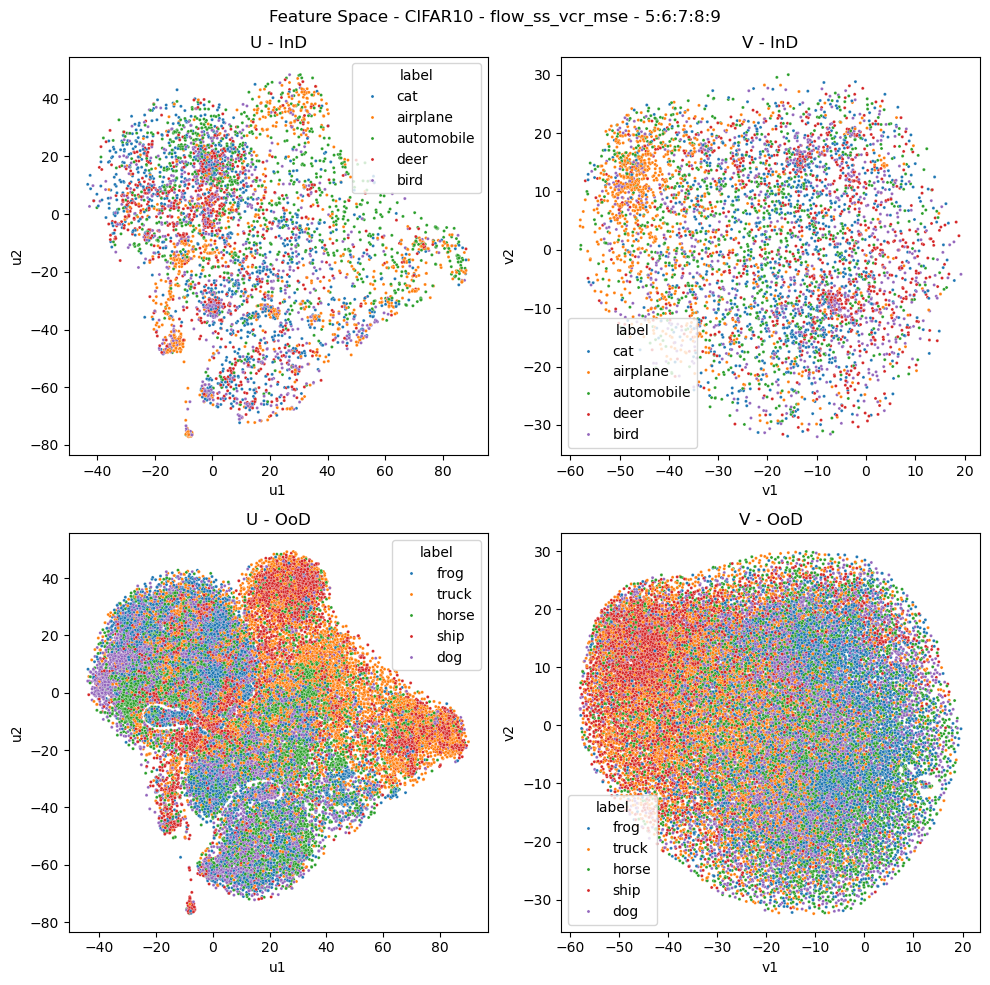

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.39s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.50s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:04<00:01,  1.50s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.56s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.53s/it]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:06<00:18,  6.05s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:11<00:11,  5.94s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:17<00:05,  5.96s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.02s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:24<00:00,  6.00s/it]

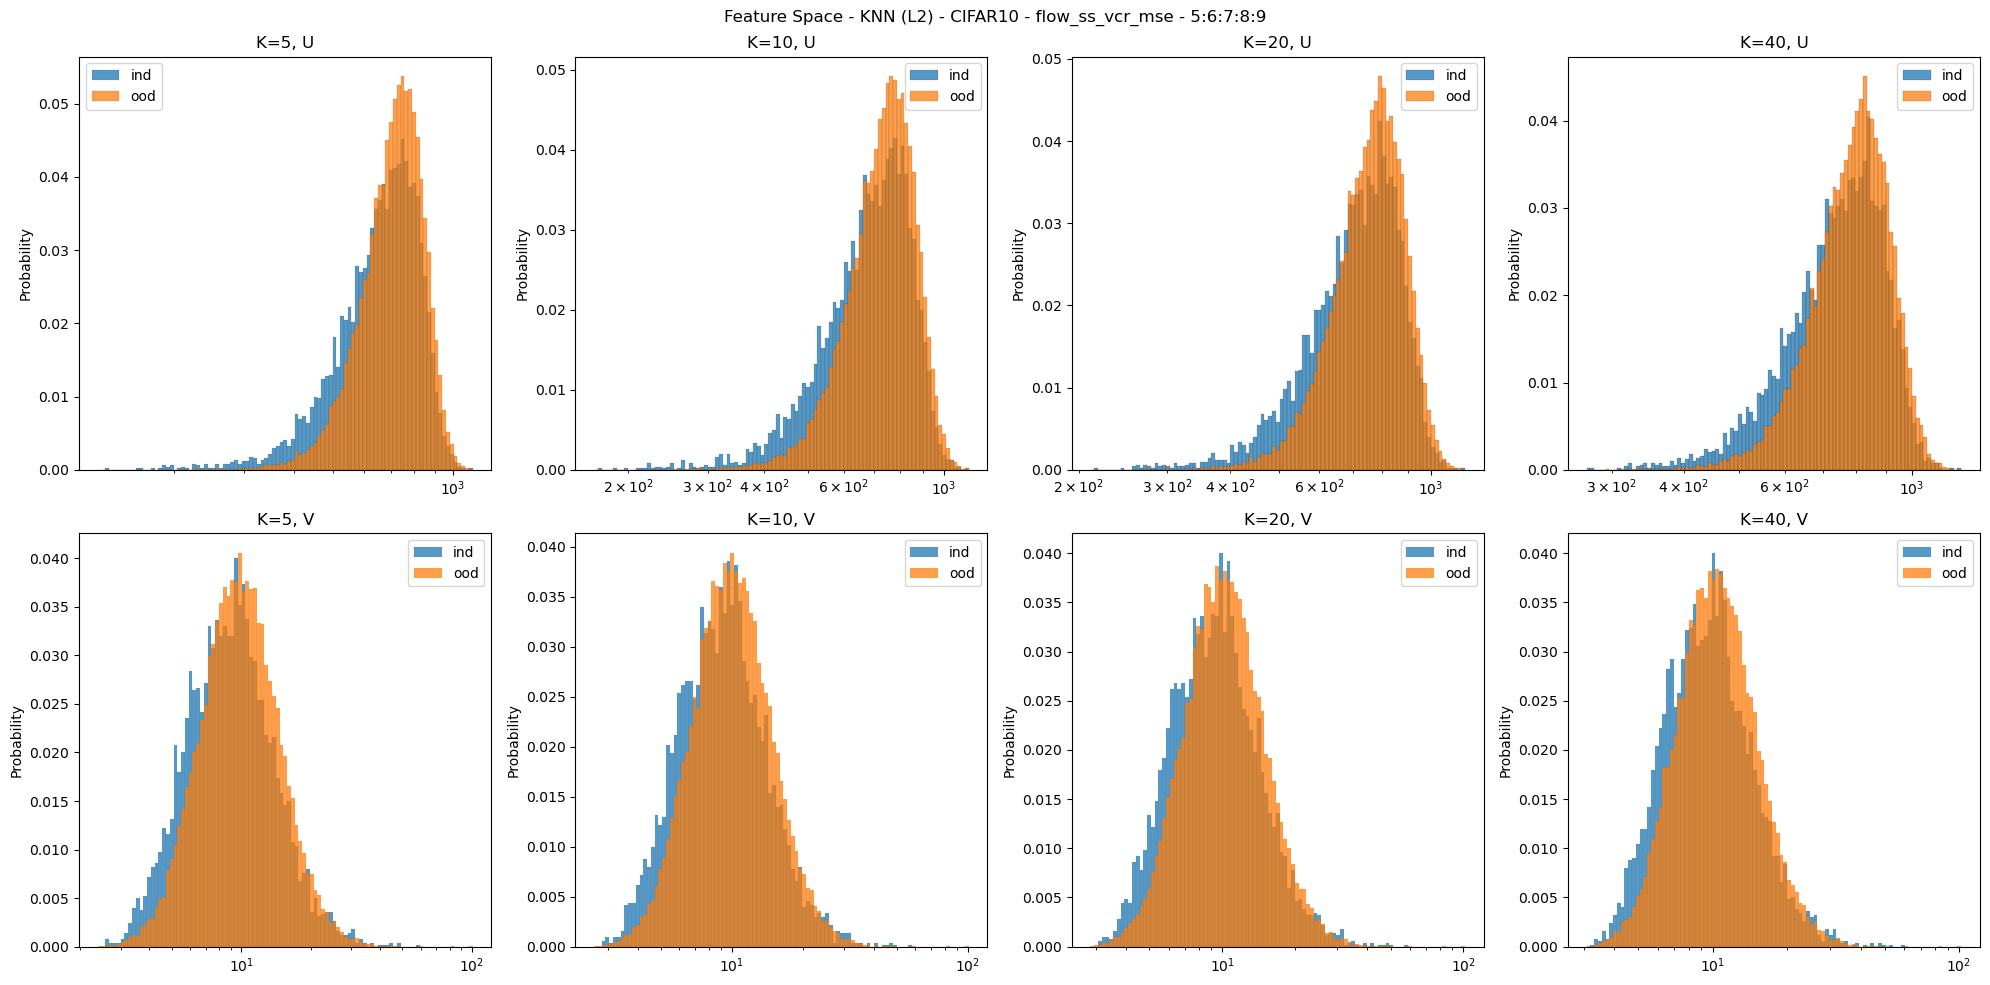

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatL2(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatL2(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:01<00:04,  1.38s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:02<00:02,  1.39s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:04<00:01,  1.43s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.51s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.47s/it]

  0%|                                                                                | 0/4 [00:00<?, ?it/s]

 25%|██████████████████                                                      | 1/4 [00:05<00:17,  5.82s/it]

 50%|████████████████████████████████████                                    | 2/4 [00:11<00:11,  5.81s/it]

 75%|██████████████████████████████████████████████████████                  | 3/4 [00:17<00:05,  5.83s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.91s/it]

100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.88s/it]

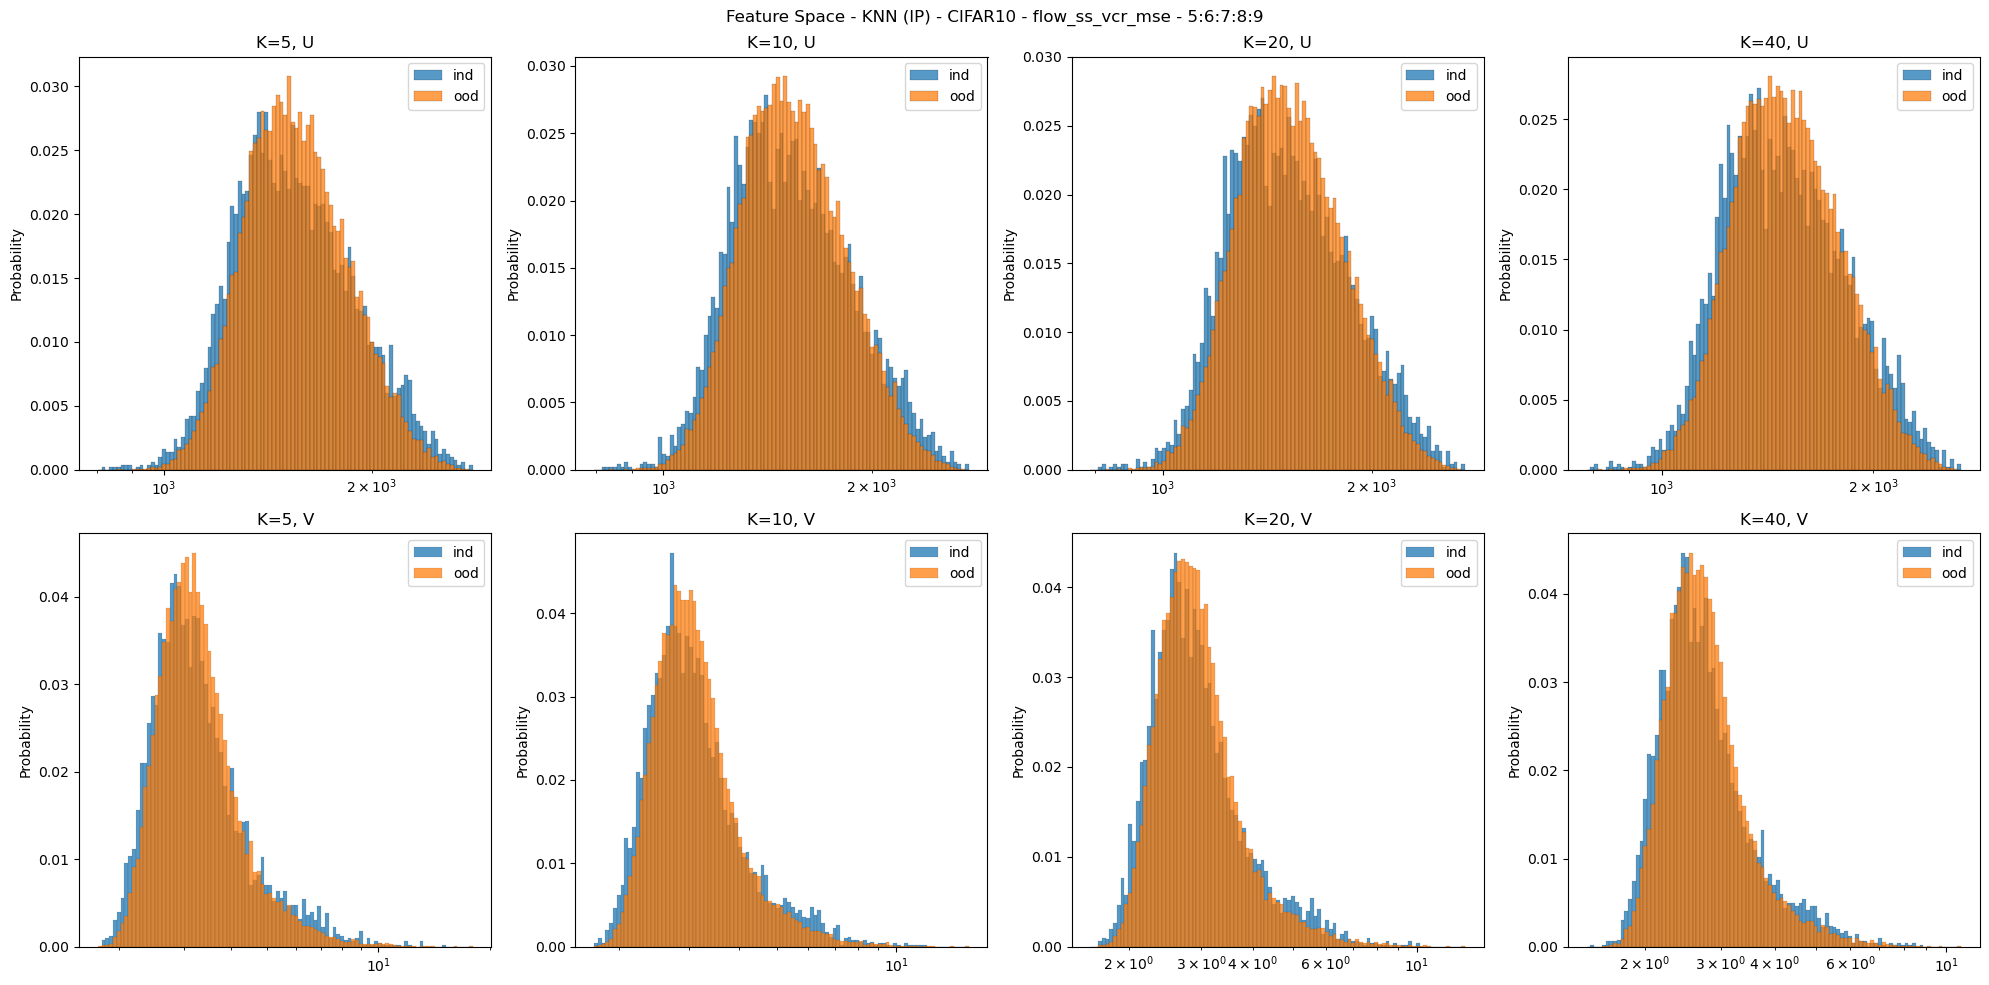

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index = faiss.IndexFlatIP(ind_e_u.shape[-1])
index.add(val_e_u)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_u, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index = faiss.IndexFlatIP(ind_e_v.shape[-1])
index.add(val_e_v)

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_e_v, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

41.809868 3.5891087 3.067444 0.68051106
41.768356 3.6619663 3.0649757 0.6858799
41.799755 3.6667728 3.069178 0.68503857
42.142574 3.1184883 3.187075 0.6400414
55.56027 2.3748868 46.27413 0.7406803


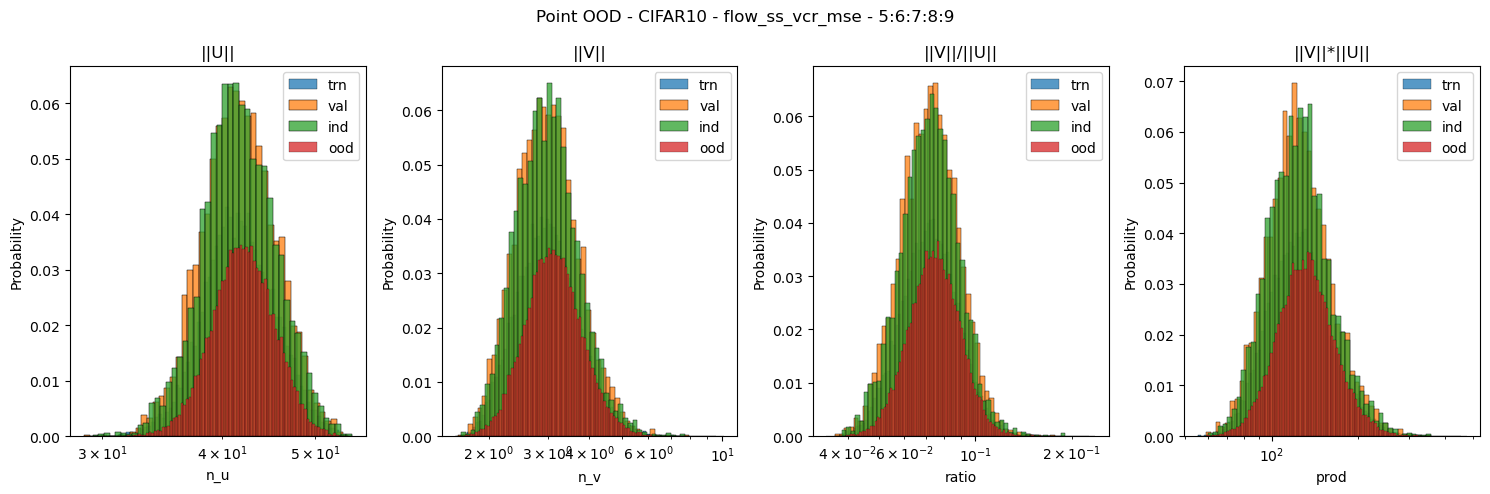

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


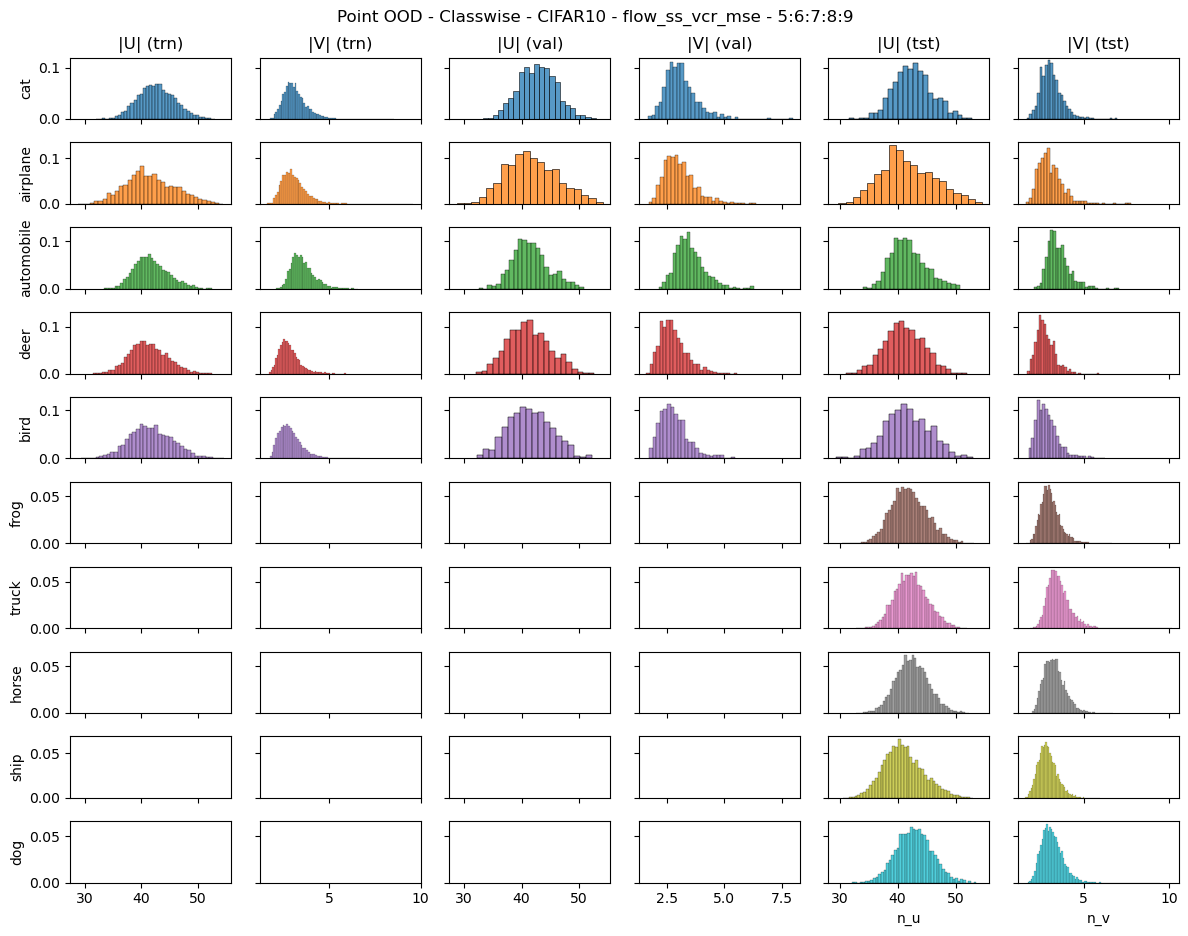

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

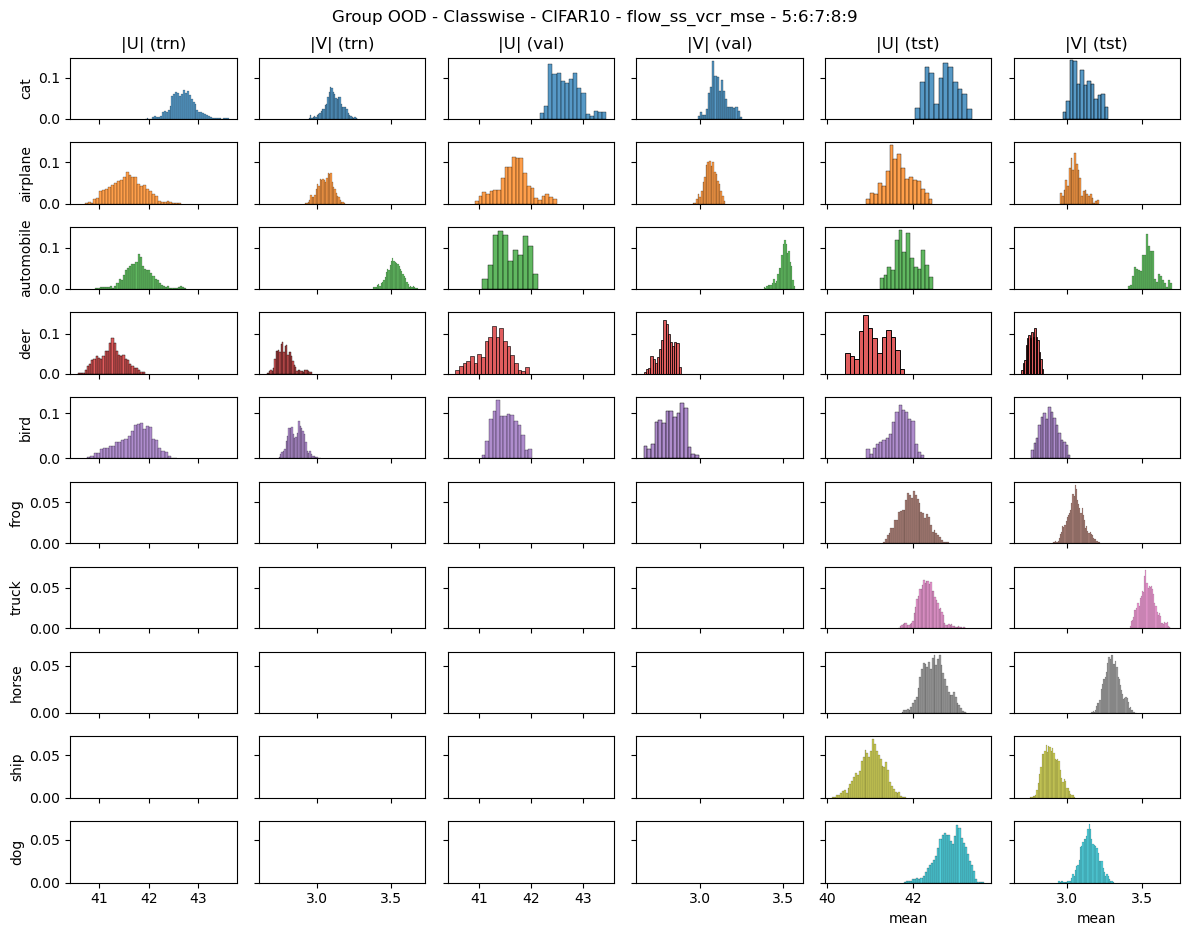

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

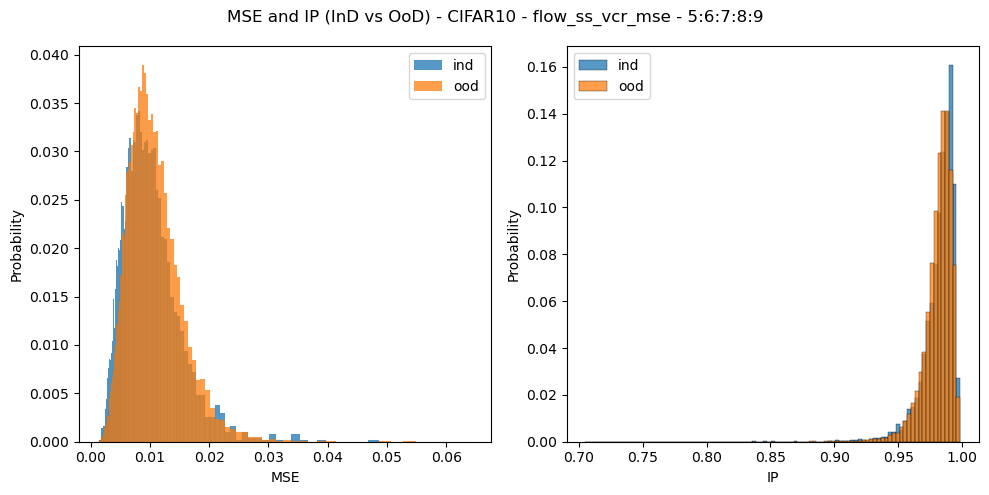

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_inp_norm = np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7
_ind_rcn_norm = np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7
ind_mse = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_ip = ((_ind_inp/_ind_inp_norm) * (_ind_rcn/_ind_rcn_norm)).sum(-1)
df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ind_tgt, mse=ind_mse, ip=ind_ip, source="ind"))], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_inp_norm = np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7
    _ood_rcn_norm = np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7
    ood_mse = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_ip = ((_ood_inp/_ood_inp_norm) * (_ood_rcn/_ood_rcn_norm)).sum(-1)
    df_rstat = pd.concat([df_rstat, pd.DataFrame(dict(target=ood_tgt, mse=ood_mse, ip=ood_ip, source="ood"))], ignore_index=True)
    
bins_mse = np.logspace(np.log10(df_rstat['mse'].min() + 1e-7), np.log10(df_rstat['mse'].max()), 100)
bins_ip = np.linspace(df_rstat['ip'].min(), df_rstat['ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="mse", label="ind", stat="probability", bins=bins_mse, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="ip", label="ind", stat="probability", bins=bins_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="mse", label="ood", stat="probability", bins=bins_mse, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="ip", label="ood", stat="probability", bins=bins_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("MSE")
ax2.set_xlabel("IP")
plt.suptitle(f"MSE and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()